# 温調測定ノート
[サンプルデータ GitHubリンク](https://github.com/T-Ando6630/naruse-lab.git)

In [1]:
import os, datetime, glob
import tkinter
from tkinter import filedialog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters, Parameter

## 共振解析

In [4]:
root = tkinter.Tk()
root.withdraw()
fld = filedialog.askdirectory(title ="Import")
##保存先のディレクトリを作成
InitialDir=os.getcwd()
date=datetime.datetime.now()
date=date.strftime('%Y%m%d_tmp')
Fpath=os.path.join(fld,date)
res=os.path.exists(Fpath)
if res==0:
    os.mkdir(Fpath)
os.chdir(Fpath)
print(Fpath)

C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp\20200206_tmp


In [5]:
data0 = glob.glob(fld+'/1-'+'*.txt')
data1 = glob.glob(fld+'/2-'+'*.txt')
data2 = glob.glob(fld+'/3-'+'*.txt')
data3 = glob.glob(fld+'/4-'+'*.txt')
data4 = glob.glob(fld+'/5-'+'*.txt')
data5 = glob.glob(fld+'/6-'+'*.txt')
data6 = glob.glob(fld+'/7-'+'*.txt')
data7 = glob.glob(fld+'/8-'+'*.txt')
dset=list([data0,data1,data2,data3,data4,data5,data6,data7])
print(data0[0])

C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp\1-1007.txt


In [6]:
#フィッティング
def lorentz(x,amplitude,center,sigma,m,b):
    out = amplitude/np.pi * (sigma/((x-center)**2+sigma**2)) + m * x + b
    return out

class FrTemp():
    def __init__(self,data,save=False):
        df = []
        fr = np.array([])
        for path in data:
            t = os.path.splitext(path)[0]
            t = int(t.split('-',1)[1])
            df0 = pd.read_csv(path,engine='python',header=None,sep='    ',index_col=0,names=('freq',t))
            df.append(df0)
        self.df = pd.concat(df,axis=1)
        self.df.sort_index(axis=1,ascending=True,inplace=True)
        self.result = self.fit(self.df)
    def fit(self,df):
        out = []
        for col in df.columns:
            df1 = df.copy()
            df1 = df1[col]
            df1.dropna(how='any',inplace=True)
            #フィッティング  
            mod = Model(lorentz)
            par = Parameters()
            mask = df1 == df1.min()
            amp = pow(10,df1.values/10)
            x = df1.index.values * pow(10,-9)
            center = float(x[mask])
            par['amplitude'] = Parameter(name='amplitude',value=np.pi*(1-amp.min())*(x.max()-x.min())/20,vary=True)
            par['center']    = Parameter(name='center',value=center,min=center*0.9,max=center*1.1,vary=True)
            par['sigma']     = Parameter(name='sigma',value=pow(10,-5),min=0,max=1,vary=True)
            par['m']         = Parameter(name='m',value=0,vary=True)
            par['b']         = Parameter(name='b',value=1,vary=True)
            par['height']    = Parameter(name='height',expr='abs(amplitude/sigma/pi)',vary=False)
            par['fwhm']      = Parameter(name='fwhm',expr='2*sigma',vary=False)
            par['Ql']        = Parameter(name='Ql',expr='center/fwhm',vary=False)
            par['Qc']        = Parameter(name='Qc',expr='Ql/(1-height)',vary=False)
            par['Qi']        = Parameter(name='Qi',expr='Ql/height',vary=False)
            result = mod.fit(amp,par,x=x)
            result = pd.Series(result.values,name=str(col))
            out.append(result)
        out = pd.concat(out,axis=1)
        out = out.T
        out.index.rename('T[mK]',inplace=True)
        out['fwhm'] = out['fwhm']*pow(10,6)
        out.rename(columns={'center':'fr[GHz]','m':'slope','b':'const','fwhm':'FWHM[kHz]'},inplace=True)
        out.insert(loc=2,column='delta[kHz]',value=(out['fr[GHz]']-out['fr[GHz]'].iloc[0])*pow(10,6))
        return out

In [10]:
#実行＆csv出力
freqs = []
for data in dset:
    out = FrTemp(data,save=False)
    name = round(float(out.result['fr[GHz]'].iloc[0]),2)
    out.result.to_csv('fit_'+str(name)+'.csv')
    freqs.append(out)

In [ ]:
os.chdir(InitialDir)

## 温調解析

In [11]:
root = tkinter.Tk()
root.withdraw()
fld = filedialog.askdirectory(title='import fitCSV')
dlist = glob.glob(os.path.join(fld,'fit_'+'*.csv'))
print(len(dlist),dlist)

8 ['C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.25.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.3.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.38.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.47.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.53.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.61.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.69.csv', 'C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp/20200206_tmp\\fit_3.75.csv']


In [12]:
item = []
for path in dlist:
    df0 = pd.read_csv(path,engine='python',header=0)
    item.append(df0)

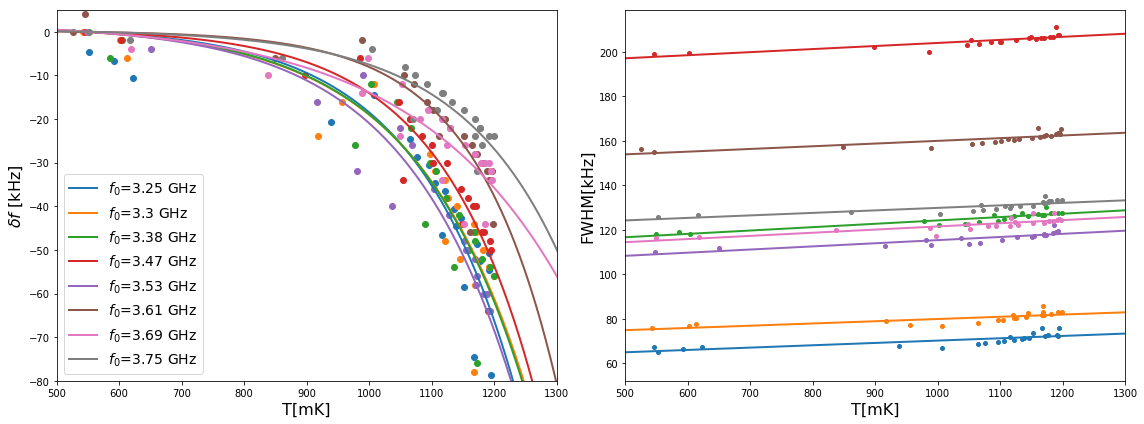

In [13]:
import scipy.optimize

t = np.arange(1,1501)
f = []
p0 = []
p1 = []

fig, ax = plt.subplots(1,2,figsize=(16,6))
for df in item :
    fr = df['fr[GHz]'].iloc[0]
    f.append(fr)
    mask = df['Qi'] < 400000
    df = df[mask]
    mask1 = df['T[mK]']>500
    mask2 = df['T[mK]']<1200
    mask = mask1&mask2                   
    x0 = df.loc[mask,'T[mK]']
    y0 = df.loc[mask,'delta[kHz]']
    def temp(t,a,b):
        return a * (1 - np.exp(b*(t/x0[0] - 1)))
                   
    init = np.array([0.1,1])
    param0, pcov = scipy.optimize.curve_fit(temp,x0,y0,init,maxfev=1000)
    fit0 = temp(t,param0[0],param0[1])
    p0.append(param0)
    
    line, = ax[0].plot(t,fit0,linewidth=2)
    ax[0].scatter(x0, y0, color=line.get_color(),marker='o')
    x1 = df.loc[mask,'T[mK]']
    y1 = df.loc[mask,'FWHM[kHz]']
    ax[1].plot(x1,y1,color=line.get_color(),marker='.',markersize=8,linestyle='None')
    param1 = np.polyfit(x1,y1,1)
    fit1 = np.poly1d(param1)(t)
    ax[1].plot(t,fit1,linewidth=2)
    p1.append(param1)
f = np.array(f)
f = f.round(2)
ax[0].set_xlim(500,1300)
ax[0].set_ylim(-80,5)
ax[0].set_xlabel('T[mK]',fontsize=16)
ax[0].set_ylabel('$\delta f$ [kHz]',fontsize=16)
ax[0].legend(list(map(lambda f:'$f\it_{0}$='+str(f)+' GHz',f)),fontsize=14)
ax[1].set_xlim(500,1300)
ax[1].set_xlabel('T[mK]',fontsize=16)
ax[1].set_ylabel('FWHM[kHz]',fontsize=16)
fig.tight_layout()
plt.savefig('t-deltaF&FWHM.png')
plt.show()

In [14]:
par0 = pd.DataFrame(p0)
par1 = pd.DataFrame(p1)
pars = pd.concat([par0,par1],axis=1)
pars.index = f
pars.index.rename('fr[GHz]',inplace=True)
pars.columns = ['a0','b0','a1','b1'] 
pars.to_csv('delta_fitpars.csv')
pars.head()

,a0,b0,a1,b1
fr[GHz],,,,
3.25,1.203755,3.360511,0.010497,59.775105
3.30,1.623901,3.020219,0.010033,69.940739
3.38,1.627996,3.088778,0.015120,109.145128
3.47,0.778898,3.545393,0.013779,190.235400
3.53,1.781274,3.088012,0.014111,101.307522


In [15]:
def ampT(T,t0,f0,amplitude,m,b,a0,b0,a1,b1):
    out = amplitude/np.pi * (HWHM(T,a1,b1)*pow(10,-6)/((deltaf(T,a0,b0,t0)*pow(10,-6))**2+(HWHM(T,a1,b1)*pow(10,-6))**2)) + m * f0 + b
    return out

def deltaf(T,a,b,t0):
    out = a * (1 - np.exp(b * (T/t0 - 1)))
    return out

def HWHM(T,a,b):
    out = (a * T + b)/2
    return out

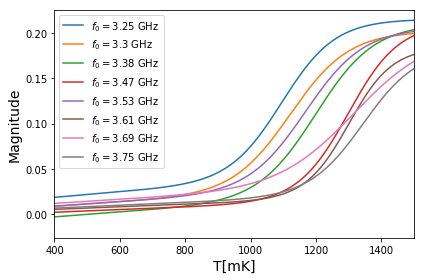

In [16]:
t = np.arange(1,1501)
out = []
fig,ax = plt.subplots()
for i, df in enumerate (item) :
    t0, amplitude,f0,m,b = df[['T[mK]','amplitude','fr[GHz]','slope','const']].iloc[0]
    a0,b0,a1,b1 = pars[['a0','b0','a1','b1']].iloc[i]
    mag = ampT(t,t0,f0,amplitude,m,b,a0,b0,a1,b1)

    ax.plot(t,mag,label='$f\it_{0}=$'+str(np.array(f)[i].round(2))+' GHz')
    out.append(mag)
ax.set_xlim(400,1500)
ax.set_xlabel('T[mK]',fontsize=14)
ax.set_ylabel('Magnitude',fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('T-Mag0.png')
plt.show()

In [17]:
tMag=pd.DataFrame(out).T
tMag.index.rename('T[mK]',inplace=True)
tMag.columns = f.tolist()
tMag.to_csv('T-Mag.csv')
tMag.head()

,3.25,3.3,3.38,3.47,3.53,3.61,3.69,3.75
T[mK],,,,,,,,
0,0.005008,-0.001983,-0.014618,-0.003893,-0.002022,-0.000530,0.002286,-0.000013
1,0.005045,-0.001954,-0.014587,-0.003877,-0.001993,-0.000515,0.002312,0.000004
2,0.005082,-0.001925,-0.014556,-0.003862,-0.001965,-0.000500,0.002338,0.000022
3,0.005118,-0.001897,-0.014525,-0.003846,-0.001936,-0.000484,0.002363,0.000039
4,0.005155,-0.001868,-0.014494,-0.003830,-0.001907,-0.000469,0.002389,0.000056


### アルファ線の解析データから温度を推定

In [381]:
os.getcwd()

'C:\\Users\\USER\\Desktop\\study\\進捗\\20191010_温調\\20191010frtemp\\20200129_tmp'

In [154]:
#ファイルをインポート
root = tkinter.Tk()
root.withdraw()
file = tkinter.filedialog.askopenfilename(title='import T-Mag CSV',
                                          filetypes = [("datafiles","*.csv;*.txt;*.dat;*.hws")])
                
tMag = pd.read_csv(file,engine='python',header=0,index_col='T[mK]')
tMag.head()

,3.25,3.3,3.38,3.47,3.53,3.61,3.69,3.75
T[mK],,,,,,,,
0,0.005008,-0.001983,-0.014618,-0.003893,-0.002022,-0.000530,0.002286,-0.000013
1,0.005045,-0.001954,-0.014587,-0.003877,-0.001993,-0.000515,0.002312,0.000004
2,0.005082,-0.001925,-0.014556,-0.003862,-0.001965,-0.000500,0.002338,0.000022
3,0.005118,-0.001897,-0.014525,-0.003846,-0.001936,-0.000484,0.002363,0.000039
4,0.005155,-0.001868,-0.014494,-0.003830,-0.001907,-0.000469,0.002389,0.000056


In [18]:
#ファイルをインポート
root = tkinter.Tk()
root.withdraw()
file = tkinter.filedialog.askopenfilename(title='import eResolution CSV',
                                          filetypes = [("datafiles","*.csv;*.txt;*.dat;*.hws")])
                
resolution = pd.read_csv(file,engine='python',header=0,index_col='fr[GHz]')
resolution.head()

,width[μm],Baseline[mV],Noise[mV],Signal[mV],S/N,FWHM[mV],Resolution
fr[GHz],,,,,,,
3.25,3,-0.00021,1.88,58.44,31.1,2.166,29.9
3.30,3,-0.02616,1.87,73.94,39.6,2.379,37.5
3.34,3,-0.01626,1.96,97.53,49.7,3.187,35.9
3.47,5,0.00483,1.86,79.13,42.5,2.612,35.7
3.53,5,-0.01096,1.74,74.29,42.7,2.356,38.0


In [27]:
def deltaT(n):
    s0 = pow(10,freqs[n].df.iloc[:,0].dropna().min()/10)
    s1 = signal[n]
    mask = (s0+s1)>tMag.iloc[:,n]
    col = tMag.iloc[:,n].name
    mag1 = tMag.loc[mask,col].tail(1)
    name=mag1.name
    mag1.rename('Magnitude',inplace=True)
    mag1=pd.DataFrame(mag1)
    mag1.reset_index(inplace=True)
    mag1.index=[name]
    mag1.index.rename('$f\it_{0}$ [GHz]',inplace=True)
    mag1['Baseline'] = s0
    mag1['T$\it_{0}$[mK]'] = freqs[n].df.columns[0]
    mag1['$\delta$T[mK]'] = mag1['T[mK]']-freqs[n].df.columns[0]
    mag1=mag1[['Baseline','Magnitude','T$\it_{0}$[mK]','T[mK]','$\delta$T[mK]']]
    return mag1

signal = (resolution['Signal[mV]']/pow(10,3)).values
deltaMT = []
for num in range(tMag.shape[1]):
    deltaMT.append(deltaT(num))
deltaMT = pd.concat(deltaMT)
deltaMT.index = deltaMT.index.astype('float')

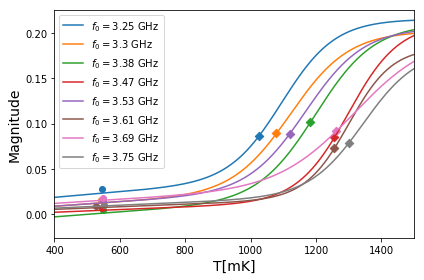

In [28]:
#温度推定まとめ  
t = np.arange(1,1501,0.1)
out = []
labels = []
fig,ax = plt.subplots()
for i, df in enumerate (item) :
    t0,amplitude,f0,m,b = df[['T[mK]','amplitude','fr[GHz]','slope','const']].iloc[0]
    a0,b0,a1,b1 = pars[['a0','b0','a1','b1']].iloc[i]
    mag = ampT(t,t0,f0,amplitude,m,b,a0,b0,a1,b1)
    line, = ax.plot(t,mag)
    ax.scatter(deltaMT.loc[f[i],'T$\it_{0}$[mK]'],deltaMT.loc[f[i],'Baseline'],color=line.get_color(),marker='o')
    ax.scatter(deltaMT.loc[f[i],'T[mK]'],deltaMT.loc[f[i],'Magnitude'],color=line.get_color(),marker='D')
    labels.append('$f\it_{0}=$'+str(np.array(f)[i].round(2))+' GHz')
    out.append(mag)
ax.set_xlim(400,1500)
ax.set_xlabel('T[mK]',fontsize=14)
ax.set_ylabel('Magnitude',fontsize=14)
ax.legend(labels,fontsize=10)
plt.tight_layout()
plt.savefig('T-Magdelta.png')
plt.show()

### Nqp推定

In [171]:
t = np.arange(1,1501)

Tc = 9.2
volume = np.array([2227,2127,2027,4009,3829,5791,5531,7573])
eta = 0.57
kb = 1.38 * pow(10,-23)
N0 = 1.72 * pow(10,10)
delta = 1.54 * kb * Tc 
def Nqpfunc(T,Tc,volume):
    nqp = (2 * N0 *volume *  np.sqrt(2*np.pi * kb * T * delta) * np.exp(-delta / (kb*T)))/(1.6*pow(10,-19))
    return nqp
N = [Nqpfunc(t*pow(10,-3),Tc,V) for V in volume]

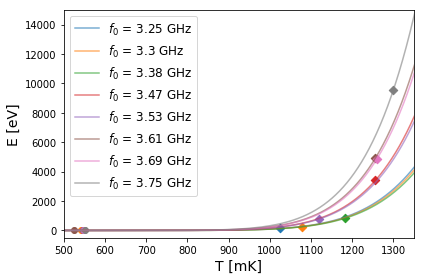

In [188]:
fig, ax = plt.subplots(figsize=(6,4))
labels = []
absE = []
Et = []
for i,Nqp in enumerate(N) :
    Nqp = pd.Series(Nqp,index=t)
    E = delta/(1.6*pow(10,-19))/eta * Nqp
    line, = ax.plot(E,alpha=.6)
    tn0 = deltaMT.loc[f[i],'T$\it_{0}$[mK]']
    tn1 = deltaMT.loc[f[i],'T[mK]']
    ax.scatter(tn0,E[tn0], color=line.get_color(), marker='o')
    ax.scatter(tn1,E[tn1], color=line.get_color(), marker='D')
    labels.append('$f\it_{0}$ = '+str(f[i])+' GHz')
    absE.append(E[tn1]-E[tn0])
    Et.append(E)
ax.set_xlim(500,1350)
ax.set_ylim(-500,15000)
ax.set_xlabel('T [mK]',fontsize=14)
ax.set_ylabel('E [eV]',fontsize=14)
ax.legend(labels,fontsize=12)
fig.tight_layout()
plt.savefig('E-T.png')
plt.show()
Et = pd.concat(Et,axis=1)
Et.columns = f

In [190]:
abEN = deltaMT.copy()
abEN['Eabs[eV]'] = absE
abEN.to_csv('Eabso.csv')
abEN

,Baseline,Magnitude,T$\it_{0}$[mK],T[mK],$\delta$T[mK],Eabs[eV]
$f\it_{0}$ [GHz],,,,,,
3.25,0.028240,0.086452,546,1025,479,134.377324
3.30,0.015748,0.089561,543,1079,536,262.997530
3.38,0.004257,0.101497,549,1182,633,823.686096
3.47,0.006439,0.085125,546,1256,710,3402.772393
3.53,0.014974,0.088861,548,1119,571,770.938285
3.61,0.009313,0.073155,526,1256,730,4915.305172
3.69,0.017513,0.091256,550,1260,710,4873.524628
3.75,0.010457,0.078828,552,1300,748,9579.710113


### サンプル

In [25]:
#ファイルをインポート
root = tkinter.Tk()
root.withdraw()
file = tkinter.filedialog.askopenfilename(title='import result CSV',
                                          filetypes = [("datafiles","*.csv;*.txt;*.dat;*.hws")])
                
result = pd.read_csv(file,engine='python',header=0,index_col=0)
result.head()

,Baseline,Magnitude,T$\it_{0}$[mK],T[mK],$\delta$T[mK],deltaN,Eabs[eV]
$f\it_{0}$ [GHz],,,,,,,
3.25,0.028240,0.086615,546,1021,475,5.926058e+04,127.045321
3.30,0.015748,0.089576,543,1082,539,1.274011e+05,273.127749
3.38,0.004257,0.101533,549,1183,634,3.882871e+05,832.426231
3.47,0.006439,0.084981,546,1256,710,1.587231e+06,3402.772393
3.53,0.014974,0.089190,548,1125,577,3.857577e+05,827.003705


In [26]:
result['volume[um3]']=volume

In [27]:
result = result.reset_index().sort_values('volume[um3]').set_index('volume[um3]')

In [28]:
result.to_csv('result20200201.csv')